In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

In [122]:
# 2009年以前のデータを用いる（final_data_train）
final_df = pd.read_csv("csv_merged/finel_data_train.csv", sep=",")
final_df.head(3)

,race_id,frame_number,horse_number,age,burden_weight,horse_weight,date,is_senba,is_mesu,is_osu,...,win_times_rate_fmf,win_jusyo_rate_fmf,win_special_rate_fmf,win_plane_rate_fmf,win_turf_rate_fmf,win_dirt_rate_fmf,EI_fmf,is_tansyo,is_hukusyo,rank_category
0,200805010101,2.0,4.0,3.0,54.0,416.0,2008-02-02 10:00:00,0.0,1.0,0.0,...,0.176471,0.000000,0.000000,0.230769,0.142857,0.200000,0.42,0,0,2
1,200805010101,7.0,13.0,3.0,54.0,454.0,2008-02-02 10:00:00,0.0,1.0,0.0,...,0.097969,0.033058,0.070493,0.109411,0.081967,0.113242,1.02,0,0,2
2,200805010101,8.0,15.0,3.0,54.0,486.0,2008-02-02 10:00:00,0.0,1.0,0.0,...,0.105213,0.078358,0.089219,0.111233,0.098446,0.111266,1.33,0,0,1


In [123]:
target_name = 'rank_category'

In [124]:
def label_split_and_drop(X_df, target_name):
    """
    target_nameをYに分割して、Xから余分なカラムを削除
    """
    Y = X_df[target_name]
    X = X_df.drop(['is_tansyo','is_hukusyo','rank_category','date','race_id'], axis=1)
    #sc = StandardScaler()
    #X = sc.fit_transform(X)
    return X, Y

def train_test_time_split(dataflame, train_ratio=0.8):
    """
    時系列を加味してデータをsplit
    """
    X = dataflame.sort_values("date")
    train_size = int(len(X) * train_ratio)
    
    return X[0:train_size].copy().reset_index(drop=True), X[train_size:len(X)].copy().reset_index(drop=True)

def eval_valid_time_split(X,Y, train_ratio=0.8):
    """
    時系列を加味してデータをsplit
    """
    train_size = int(len(X) * train_ratio)
    
    return X[0:train_size].copy(), X[train_size:len(X)].copy(), Y[0:train_size].copy(), Y[train_size:len(X)].copy()

In [125]:
# train と test に分割
train_df, test_df = train_test_time_split(final_df)
X_train, y_train = label_split_and_drop(train_df, target_name)
X_test, y_test = label_split_and_drop(test_df, target_name)


# テスト用のデータを評価用と検証用に分ける
X_eval, X_valid, y_eval, y_valid = eval_valid_time_split(X_test, y_test)

In [126]:
type(X_train)

pandas.core.frame.DataFrame

In [127]:
# LightGBM のハイパーパラメータ
lgbm_params = {
        # 多値分類問題
        'objective': 'multiclass',
        # クラス数は 3
        'num_class': 3,
        'metric': {'multi_logloss','multi_error'},
        'seed':0,
        'learning_rate' :0.02,
        'num_leaves': 32
    
}

In [128]:

from sklearn.metrics import accuracy_score

# データセットを生成する
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)

# 上記のパラメータでモデルを学習する
model = lgb.train(lgbm_params, lgb_train,
                      # モデルの評価用データを渡す
                      valid_sets=lgb_eval,
                      # 最大で 1000 ラウンドまで学習する
                      num_boost_round=1000,
                      # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                      early_stopping_rounds=100,
                      verbose_eval=10)

# 学習したモデルでホールドアウト検証する
y_pred_proba = model.predict(X_valid, num_iteration=model.best_iteration)
# 返り値は確率になっているので最尤に寄せる
y_pred = np.argmax(y_pred_proba, axis=1)

# 精度 (Accuracy) を計算する
accuracy = accuracy_score(y_valid, y_pred)
print(accuracy)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13739
[LightGBM] [Info] Number of data points in the train set: 33715, number of used features: 121
[LightGBM] [Info] Start training from score -1.620623
[LightGBM] [Info] Start training from score -1.333691
[LightGBM] [Info] Start training from score -0.618556
Training until validation scores don't improve for 100 rounds
[10]	valid_0's multi_error: 0.453062	valid_0's multi_logloss: 0.97627
[20]	valid_0's multi_error: 0.453062	valid_0's multi_logloss: 0.961908
[30]	valid_0's multi_error: 0.453062	valid_0's multi_logloss: 0.952035
[40]	valid_0's multi_error: 0.440902	valid_0's multi_logloss: 0.944984
[50]	valid_0's multi_error: 0.436601	valid_0's multi_logloss: 0.939926
[60]	valid_0's multi_error: 0.430965	valid_0's multi_logloss: 0.

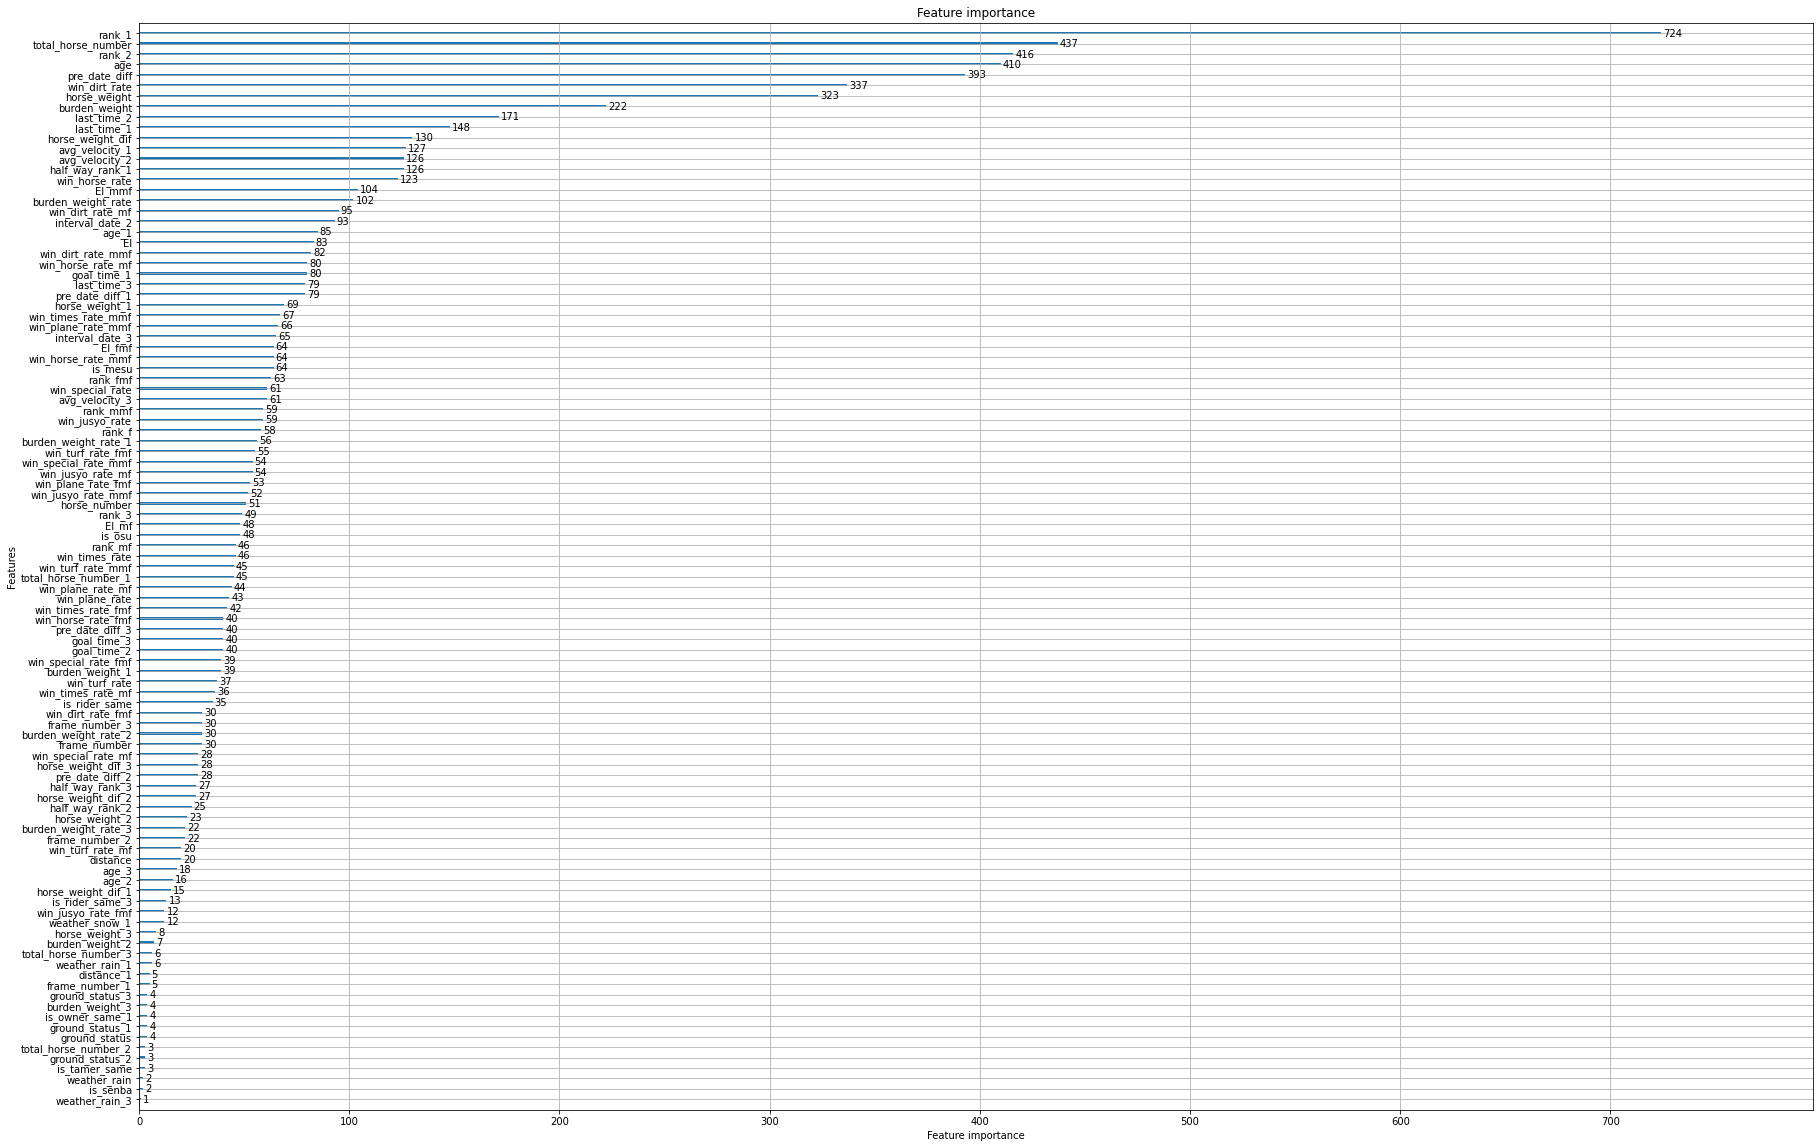

In [129]:
# 特徴量の重要度をプロットする
lgb.plot_importance(model, figsize=(30, 20))
plt.show()


In [130]:
import pickle 
file = 'model/simple.pickle'
pickle.dump(model, open(file, 'wb'))

## 2009年以降のテストデータの予測値を保存

In [131]:
# 2009年~のデータを用いる（final_data_train）
test_df = pd.read_csv("csv_merged/finel_data_test.csv", sep=",")

In [132]:
X_test_df, y_test_df = label_split_and_drop(test_df, target_name)
# 学習したモデルでホールドアウト検証する
y_pred_proba = model.predict(X_test_df, num_iteration=model.best_iteration)
# 返り値は確率になっているので最尤に寄せる
y_pred = np.argmax(y_pred_proba, axis=1)
# 精度 (Accuracy) を計算する
accuracy = accuracy_score(y_test_df, y_pred)
print(accuracy)

0.5533033033033034


In [133]:
y_pred_proba[:,0]

array([0.11346673, 0.11632785, 0.14970231, ..., 0.46867805, 0.11176753,
       0.12696243])

In [134]:
y_pred_proba = y_pred_proba[:,0].flatten()
y_pred_se = pd.Series(data=y_pred_proba, name="predict_0_prob", dtype='float')

In [135]:
predicted_test_df = pd.concat([test_df, y_pred_se], axis=1)
predicted_test_df.to_csv("predict/simple_lgb_predicted_test.csv", index=False)